In [1]:
"""
Downloaded a geometry from the internet, and want to know what it is and how to make a random catalog from it
"""

from astropy.io import fits

fname = "../data/boss_geometry_2012_11_19.fits"   # change if needed

hdul = fits.open(fname)
hdul.info()


Filename: ../data/boss_geometry_2012_11_19.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1                1 BinTableHDU     64   32561R x 19C   [36D, 12D, J, D, J, D, J, 3A, J, J, D, J, 4J, J, J, 4J, D, D, D]   


pixelization 6s                                                                  [astropy.io.fits.card]
snapped                                                                          [astropy.io.fits.card]
balkanized                                                                       [astropy.io.fits.card]


In [2]:
mask = hdul[1].data
print(mask.columns.names)


['XCAPS', 'CMCAPS', 'NCAPS', 'WEIGHT', 'PIXEL', 'STR', 'USE_CAPS', 'AREANAME', 'IBOSS', 'SECTOR', 'SECTORAREA', 'NTILES', 'TILES', 'CHUNK', 'TARGETFILE', 'CHUNKVECTOR', 'RAMID', 'DECMID', 'MASKEDAREA']


In [3]:
for name in mask.columns.names:
    print(name, mask[name].dtype)


XCAPS >f8
CMCAPS >f8
NCAPS >i4
WEIGHT >f8
PIXEL >i4
STR >f8
USE_CAPS uint32
AREANAME <U3
IBOSS >i4
SECTOR >i4
SECTORAREA >f8
NTILES >i4
TILES >i4
CHUNK >i4
TARGETFILE >i4
CHUNKVECTOR >i4
RAMID >f8
DECMID >f8
MASKEDAREA >f8


In [4]:
import numpy as np
from astropy.io import fits

with fits.open("../data/boss_geometry_2012_11_19.fits") as hdul:
    mask = hdul[1].data

# Effective area
area_eff = mask['SECTORAREA'] - mask['MASKEDAREA']

# Basic validity cuts
good = (
    (mask['WEIGHT'] > 0) &
    (area_eff > 0)
)

polys = mask[good]

print("Usable polygons:", len(polys))
print("Total usable area [deg^2]:", area_eff[good].sum())


Usable polygons: 32561
Total usable area [deg^2]: 38969.12441629465


In [5]:
import pymangle

m = pymangle.Mangle("../data/boss_geometry_2012_11_19.fits")


Got unexpected header keyword: 'SIMPLE'

OSError: Error reading mangle mask ../data/boss_geometry_2012_11_19.fits

In [ ]:
import pymangle



Number of polygons: 32561


In [2]:
from astropy.io import fits
import numpy as np
import pymangle 

ply_file = "../data/boss_geometry_2012_11_19.ply"

m = pymangle.Mangle(ply_file)
print("Number of polygons:", m.npoly)

with fits.open("../data/boss_geometry_2012_11_19.fits") as hdul:
    mask = hdul[1].data

area_eff = mask['SECTORAREA'] - mask['MASKEDAREA']

good = (
    (mask['WEIGHT'] > 0) &
    (area_eff > 0)
)

weights = area_eff[good] * mask['WEIGHT'][good]
weights /= weights.sum()

poly_ids = np.where(good)[0]

print("Usable polygons:", len(poly_ids))
print("Sum of weights:", weights.sum())


N_rand = 100_000

rng = np.random.default_rng(42)

chosen_polys = rng.choice(
    poly_ids,
    size=N_rand,
    p=weights
)

ra = []
dec = []

for ip, w in zip(poly_ids, weights):
    n_points = int(N_rand * w)
    r, d = m.genrand(n_points, poly=ip)
    ra.append(r)
    dec.append(d)

ra = np.concatenate(ra)
dec = np.concatenate(dec)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(ra, dec, s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SDSS angular random catalog")
plt.show()

from astropy.table import Table

rand = Table()
rand['RA'] = ra
rand['DEC'] = dec

rand.write("randoms_sdss_mgs_angular.fits", overwrite=True)


Number of polygons: 32561
Usable polygons: 32561
Sum of weights: 0.9999999999999999


pixelization 6s                                                                  [astropy.io.fits.card]
snapped                                                                          [astropy.io.fits.card]
balkanized                                                                       [astropy.io.fits.card]


TypeError: Mangle.genrand() takes no keyword arguments

Number of polygons: 32561


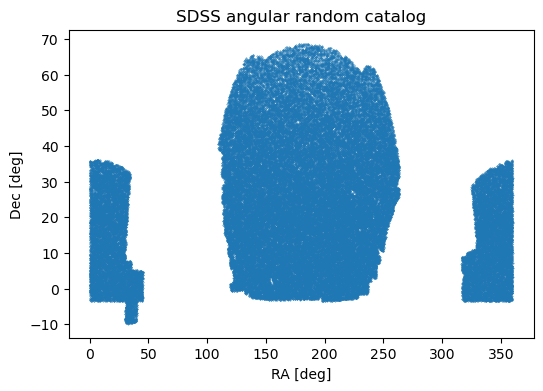

ValueError: Illegal format `float128`.

In [3]:
import pymangle
from astropy.table import Table
import matplotlib.pyplot as plt

# Load MANGLE mask
ply_file = "../data/boss_geometry_2012_11_19.ply"
m = pymangle.Mangle(ply_file)
print("Number of polygons:", m.npoly)

# Generate N_rand points
N_rand = 100_000
ra, dec = m.genrand(N_rand)  # <- simple, weighted automatically

# Quick plot
plt.figure(figsize=(6,4))
plt.scatter(ra, dec, s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SDSS angular random catalog")
plt.show()

# Save to FITS
rand = Table()
rand['RA'] = ra
rand['DEC'] = dec
rand.write("randoms_sdss_mgs_angular.fits", overwrite=True)


Generated 100000 random points in central region.


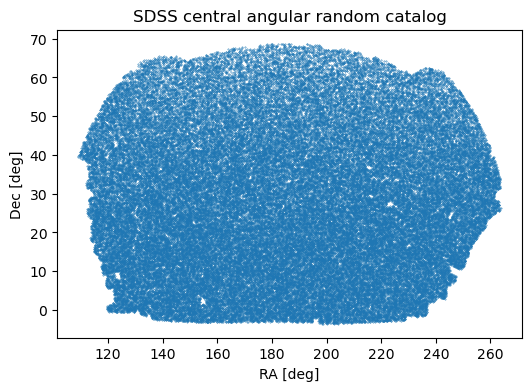

ValueError: Illegal format `float128`.

In [6]:
import pymangle
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

# -------------------------------
# Load MANGLE mask
# -------------------------------
ply_file = "../data/boss_geometry_2012_11_19.ply"
m = pymangle.Mangle(ply_file)

# -------------------------------
# Target number of points
# -------------------------------
N_target = 100_000

# -------------------------------
# Central region limits
# -------------------------------
RA_min, RA_max = 100, 300
Dec_min, Dec_max = -10, 80

# -------------------------------
# Generate random points efficiently
# -------------------------------
ra_list = []
dec_list = []

N_batch = int(N_target * 1.5)  # generate 50% extra each batch
while sum(len(a) for a in ra_list) < N_target:
    ra_tmp, dec_tmp = m.genrand(N_batch)
    
    mask = (ra_tmp >= RA_min) & (ra_tmp <= RA_max) & (dec_tmp >= Dec_min) & (dec_tmp <= Dec_max)
    ra_list.append(ra_tmp[mask])
    dec_list.append(dec_tmp[mask])

# Concatenate and trim to exactly N_target
ra_central = np.concatenate(ra_list)[:N_target]
dec_central = np.concatenate(dec_list)[:N_target]

print(f"Generated {len(ra_central)} random points in central region.")

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(6,4))
plt.scatter(ra_central, dec_central, s=0.1)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("SDSS central angular random catalog")
plt.show()

# -------------------------------
# Save to FITS
# -------------------------------
rand = Table()
rand['RA'] = ra_central
rand['DEC'] = dec_central
rand.write("randoms_sdss_mgs_central.fits", overwrite=True)
